In [108]:
import os
import time
import copy
import glob
import cv2
import shutil
import pickle
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
# parameters
label_name = 'top'
class_num = 5
result_path = 'result'
num_worker = 4
folder_name = 'top_epoch35_batch128'
weight_num = 34
weight_path = f'{result_path}/{folder_name}/{weight_num:03}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
# validation data
val_data_path = f'../dataset/resnet_dataset/{label_name}_test'

trsf = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

val_dataset = torchvision.datasets.ImageFolder(
    root= val_data_path,
    transform= trsf
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= 32,
    num_workers= num_worker,
    shuffle= True
)

print('num of validation set is', len(val_dataset))

num of validation set is 2000


In [111]:
with open(f'result/{folder_name}/train_acc_hist.pkl', 'rb') as f:
    train_acc_hist = pickle.load(f)
with open(f'result/{folder_name}/val_acc_hist.pkl', 'rb') as f:
    val_acc_hist = pickle.load(f)
with open(f'result/{folder_name}/train_loss_hist.pkl', 'rb') as f:
    train_loss_hist = pickle.load(f)
with open(f'result/{folder_name}/val_loss_hist.pkl', 'rb') as f:
    val_loss_hist = pickle.load(f)

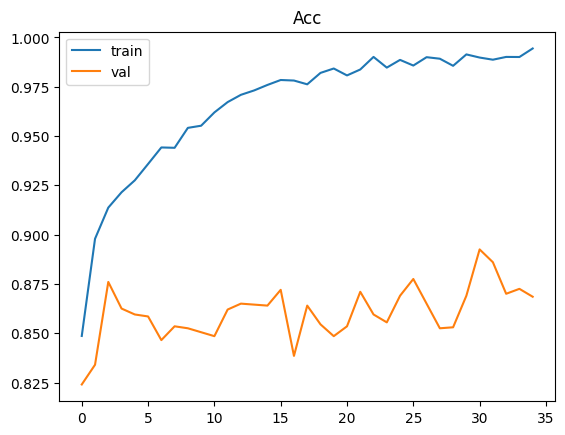

000, 0.8240, 0.5665
001, 0.8340, 0.5132
002, 0.8760, 0.3814
003, 0.8625, 0.4179
004, 0.8595, 0.4407
005, 0.8585, 0.4492
006, 0.8465, 0.5532
007, 0.8535, 0.5560
008, 0.8525, 0.5863
009, 0.8505, 0.5105
010, 0.8485, 0.5865
011, 0.8620, 0.5849
012, 0.8650, 0.5863
013, 0.8645, 0.5653
014, 0.8640, 0.6053
015, 0.8720, 0.5732
016, 0.8385, 0.8142
017, 0.8640, 0.7045
018, 0.8545, 0.6986
019, 0.8485, 0.7214
020, 0.8535, 0.7421
021, 0.8710, 0.7256
022, 0.8595, 0.7790
023, 0.8555, 0.7901
024, 0.8690, 0.7443
025, 0.8775, 0.6160
026, 0.8650, 0.7869
027, 0.8525, 0.8288
028, 0.8530, 0.8186
029, 0.8690, 0.7723
030, 0.8925, 0.6263
031, 0.8860, 0.6711
032, 0.8700, 0.7534
033, 0.8725, 0.7443
034, 0.8685, 0.8097


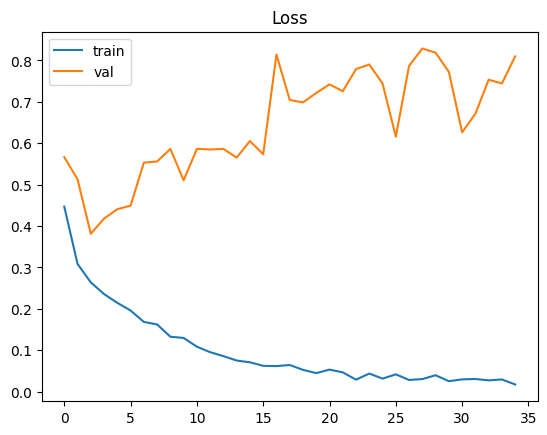

In [112]:
plt.plot(train_acc_hist, label= 'train')
plt.plot(val_acc_hist, label= 'val')
plt.title('Acc')
plt.legend()
plt.savefig(f"{result_path}/{folder_name}/acc_graph.png", bbox_inches = 'tight')
plt.show()

for idx in range(len(val_acc_hist)):
    print(f'{idx:03}, {val_acc_hist[idx]:.4f}, {val_loss_hist[idx]:.4f}')

plt.plot(train_loss_hist, label= 'train')
plt.plot(val_loss_hist, label= 'val')
plt.title('Loss')
plt.legend()
plt.savefig(f"{result_path}/{folder_name}/loss_graph.png", bbox_inches = 'tight')
plt.show()

In [113]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # clone() : 기존 텐서의 내용을 복사
    # detach() : 기존 텐서에서 기울기가 전파되지 않는 텐서
    image = image.transpose(1, 2, 0)
    image = image*(np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)

    return image

In [114]:
# 예측 결과 출력

if label_name == 'bottom':
    classes = {0 : 'long', 1 : 'shorts', 2 : 'skirt'}
elif label_name == 'onepiece':
    classes = {0 : 'jump_suite', 1 : 'onepiece'}
elif label_name == 'top':
    classes = {0 : 'half_sleeve', 1 : 'knit_sweater', 2 : 'longsleeve', 3 : 'shirts_blouse', 4 : 'sleeveless'}
else:
    print('err')

dataiter = iter(val_loader)
images, true_labels = next(dataiter)

In [115]:
model_dict = torch.load(weight_path, map_location= device)
my_model = models.resnet50()
my_model.fc = nn.Linear(2048, class_num)
my_model.load_state_dict(model_dict)
#my_model = my_model.to('cpu')

total_images = []
total_labels = []
total_preds = []
for images, true_labels in val_loader:
    output = my_model(images)
    _, preds = torch.max(output, 1)
    
    total_images.append(images)
    total_preds.append(preds)
    total_labels.append(true_labels)

In [116]:
true_labels = total_labels[0]
for label in total_labels[1:]:
    true_labels = torch.cat((true_labels, label), dim= -1)
print(len(true_labels))

preds = total_preds[0]
for label in total_preds[1:]:
    preds = torch.cat((preds, label), dim= -1)
print(len(preds))

imgs = []
for img_list in total_images:
    for img in img_list:
        imgs.append(img)
print(len(imgs))

2000
2000
2000


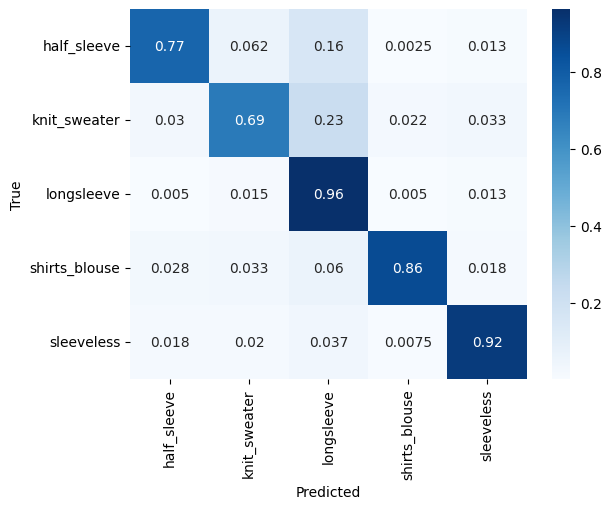

In [117]:
class_name = classes.values()
cm = confusion_matrix(true_labels, preds, normalize= 'true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels= class_name, yticklabels= class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f"{result_path}/{folder_name}/epoch{weight_num}_confusion_mat.jpg", bbox_inches = 'tight')
plt.show()

In [118]:
# fig = plt.figure(figsize= (25, 50))
# for idx in np.arange(50):
#     ax = fig.add_subplot(10, 10, idx + 1, xticks= [], yticks= [])
#     plt.imshow(im_convert(imgs[idx]))
#     ax.set_title(classes[true_labels[idx].item()])
#     ax.set_title(f'{classes[preds[idx].item()]}({classes[true_labels[idx].item()]})', color= ('blue' if preds[idx] == true_labels[idx] else 'red'))
#     # 일치하면 green, 불일치하면 red

# plt.show()
# plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)